In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Input, Activation, Dropout
from keras import backend as K
from tensorflow.keras.optimizers import Adam,SGD
import tensorflow as tf
from keras.models import Model

In [3]:
model = tf.keras.models.load_model('/content/drive/MyDrive/MPC/model0.h5')

In [4]:
# specifying constant parameters

T_0 = 300
V = 1
k_0 = 8.46*(np.power(10,6))
C_p = 0.231
rho_L = 1000
Q_s = 0.0 #Qs, Ts at unstable steady state
T_s = 402
F = 5
E = 5*(np.power(10,4))
delta_H = -1.15*(np.power(10,4))
R = 8.314
C_A0s = 4 #CA0s and CAs at unstable steady state
C_As = 1.95
t_final = 0.01 #sampling period (hr)
t_step = 1e-4 #step size (hr)
P = np.array([[1060, 22], [22, 0.52]])

In [5]:
# generate initial state conditions in deviation form
CA_initial = np.linspace(0, 6, 100, endpoint=True) - C_As
T_initial = np.linspace(300, 600, 100, endpoint=True) - T_s

# generate manipulated variables
u1_list = np.linspace(-3.5, 3.5, 4, endpoint=True) #CA0' = CA0 - CA0_s
u2_list = np.linspace(-5e5, 5e5, 4, endpoint=True) #Q' = Q - Q_s


In [6]:
# find feasible initial conditions
# i.e. in region phi_u (V(x)<=372)
CA_start=[]
T_start=[]

for CA in CA_initial:
    for T in T_initial:
        x=np.array([CA, T])
        if x.T @ P @ x <= 372:
            CA_start.append(CA)
            T_start.append(T)

# convert to np array
CA_start = np.array([CA_start])
T_start = np.array([T_start])
x_deviation = np.concatenate((CA_start, T_start), axis = 0)
x_deviation = x_deviation.T
print(x_deviation.shape)
print(x_deviation)

(771, 2)
[[ -1.6469697   64.66666667]
 [ -1.6469697   67.6969697 ]
 [ -1.6469697   70.72727273]
 ...
 [  1.62575758 -62.60606061]
 [  1.68636364 -71.6969697 ]
 [  1.68636364 -68.66666667]]


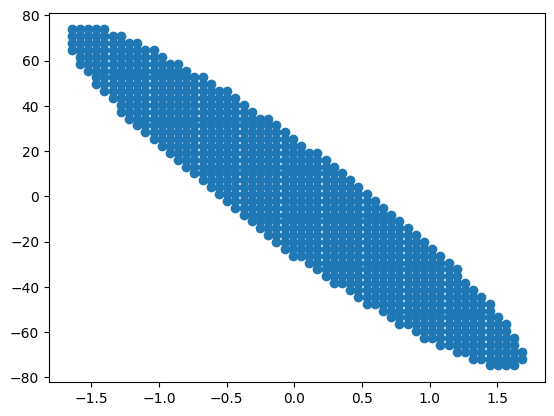

In [7]:
plt.scatter(CA_start, T_start)
plt.show()

In [8]:
# CSTR simulation
def CSTR_simulation(C_A_initial, T_initial, C_A0d, Qd):
    C_A = C_A_initial + C_As # change to CA from deviation form
    T = T_initial + T_s
    C_A0 = C_A0d + C_A0s
    Q = Qd + Q_s


    C_A_overtime = []
    T_overtime = []

    # forward euler method
    for i in range(int(t_final/t_step)):
        dCAdt = F / V * (C_A0 - C_A) - k_0 * np.exp(-E / (R * T)) * C_A**2
        dTdt = F / V * (T_0 - T) - delta_H / (rho_L * C_p) * k_0 * np.exp(-E / (R * T)) * C_A**2 + Q / (rho_L * C_p * V)

        C_A = C_A + dCAdt * t_step
        T = T + dTdt * t_step

        C_A_overtime.append(C_A- C_As) #append the deviation form
        T_overtime.append(T- T_s)

    return [C_A_overtime, T_overtime]

In [9]:
# generate trajectories for different initial conditions + control action
# give a step input to the initial steady state and see open loop response curve (i think?)
CA_input = []
T_input = []
u1_input = []
u2_input = []

CA_output = []
T_output = []

for C_A_i, T_i in x_deviation:
    for u1 in u1_list:
        for u2 in u2_list:
            [CA_out, T_out] = CSTR_simulation(C_A_i, T_i, u1, u2)
            CA_input.append(C_A_i)
            T_input.append(T_i)
            u1_input.append(u1)
            u2_input.append(u2)
            CA_output.append(CA_out)
            T_output.append(T_out)


In [10]:
test = np.array(u2_input)
print(test.mean())

-5.526330452484843e-11


In [11]:
# convert to np array for input variables
CA_input = np.array(CA_input)
CA_input = CA_input.reshape(-1, 1, 1)
print(f'CA input shape {CA_input.shape}')

T_input = np.array(T_input)
T_input = T_input.reshape(-1, 1, 1)
print(f'T input shape {T_input.shape}')

u1_input = np.array(u1_input)
u1_input = u1_input.reshape(-1, 1, 1)
print(f'CA0 input shape {u1_input.shape}')

u2_input = np.array(u2_input)
u2_input = u2_input.reshape(-1, 1, 1)
print(f'u2 input shape {u2_input.shape}, u2 input mean {u2_input.mean()}')

# combine together in terms of
# RNN_input = [no. of samples, no. of time steps, no. of input variables = 4]

RNN_input = np.concatenate((u1_input, u2_input, CA_input, T_input), axis = 2)
print(f'RNN input shape {RNN_input.shape}')

'''
currently the number of columns of input is only 1 (axis 1)
need to repeat data along axis 1 by no. of time steps
because the array dimensions of input and output need to match
initial conditions (1 set of data) but the output has 100 set of data (due to the timesteps)
'''
num_timesteps = int(t_final/t_step)
RNN_input = RNN_input.repeat(num_timesteps, axis = 1)
print(f'RNN input shape {RNN_input.shape}')

CA input shape (12336, 1, 1)
T input shape (12336, 1, 1)
CA0 input shape (12336, 1, 1)
u2 input shape (12336, 1, 1), u2 input mean -5.526330452484843e-11
RNN input shape (12336, 1, 4)
RNN input shape (12336, 100, 4)


In [12]:
# check
print(RNN_input[0,0] == RNN_input[0,99])

[ True  True  True  True]


In [13]:
# convert to np array for output variables
CA_output = np.array(CA_output)
print(f'CA output shape {CA_output.shape}')
CA_output = CA_output.reshape(-1, num_timesteps, 1)
print(f'CA output shape {CA_output.shape}')

T_output = np.array(T_output)
T_output = T_output.reshape(-1, num_timesteps, 1)
print(f'T output shape {T_output.shape}')

RNN_output = np.concatenate((CA_output, T_output), axis =2)
print(f'RNN output shape {RNN_output.shape}')

CA output shape (12336, 100)
CA output shape (12336, 100, 1)
T output shape (12336, 100, 1)
RNN output shape (12336, 100, 2)


In [ ]:
# copied over change later
num_steps = 100

X_train, X_test, y_train, y_test = train_test_split(RNN_input, RNN_output, test_size=0.3, random_state=123)

# define scalers for both X and y base on training data only
scaler_X = preprocessing.StandardScaler().fit(X_train.reshape(-1, 4))
scaler_y = preprocessing.StandardScaler().fit(y_train.reshape(-1, 2))

test2 = X_train[:,:,1]
print(test2.mean())
X_train = scaler_X.transform(X_train.reshape(-1, 4)).reshape(-1,num_steps,4)
X_test = scaler_X.transform(X_test.reshape(-1, 4)).reshape(-1,num_steps,4)
y_train = scaler_y.transform(y_train.reshape(-1,2)).reshape(-1,num_steps,2)
y_test1 = scaler_y.transform(y_test.reshape(-1,2)).reshape(-1,num_steps,2)

2219.6487164639784


In [ ]:
# compute mean and std for the data
print(f'u1, u2, CA, T, means are: {scaler_X.mean_}')
print(f'u1, u2, CA, T, std are: {scaler_X.scale_}')
print(f'y1, y2 means are {scaler_y.mean_}')
print(f'y1, y2 std are{scaler_y.scale_}')

u1, u2, CA, T, means are: [ 2.22929936e-02  2.21964872e+03  1.12851152e-02 -3.75532979e-01]
u1, u2, CA, T, std are: [2.61842124e+00 3.73068245e+05 8.48199142e-01 3.84010635e+01]
y1, y2 means are [ 0.01669856 -0.57296221]
y1, y2 std are[ 0.84197117 39.60910996]


In [ ]:
# copied over change later

model = Sequential()
model.add(SimpleRNN(64, activation='tanh', return_sequences=True))
model.add(SimpleRNN(128, activation='tanh', return_sequences=True))
model.add(Dense(2, activation='linear'))
model.compile(optimizer='adam', loss='mean_squared_error', metrics=[tf.keras.metrics.MeanSquaredError()])
history = model.fit(X_train, y_train, epochs=500, batch_size=256, validation_split=0.25, verbose=2)

Epoch 1/500
26/26 - 4s - loss: 0.1396 - mean_squared_error: 0.1396 - val_loss: 0.0358 - val_mean_squared_error: 0.0358 - 4s/epoch - 158ms/step
Epoch 2/500
26/26 - 3s - loss: 0.0247 - mean_squared_error: 0.0247 - val_loss: 0.0180 - val_mean_squared_error: 0.0180 - 3s/epoch - 115ms/step
Epoch 3/500
26/26 - 3s - loss: 0.0151 - mean_squared_error: 0.0151 - val_loss: 0.0128 - val_mean_squared_error: 0.0128 - 3s/epoch - 118ms/step
Epoch 4/500
26/26 - 3s - loss: 0.0114 - mean_squared_error: 0.0114 - val_loss: 0.0102 - val_mean_squared_error: 0.0102 - 3s/epoch - 116ms/step
Epoch 5/500
26/26 - 3s - loss: 0.0095 - mean_squared_error: 0.0095 - val_loss: 0.0088 - val_mean_squared_error: 0.0088 - 3s/epoch - 113ms/step
Epoch 6/500
26/26 - 3s - loss: 0.0083 - mean_squared_error: 0.0083 - val_loss: 0.0077 - val_mean_squared_error: 0.0077 - 3s/epoch - 116ms/step
Epoch 7/500
26/26 - 3s - loss: 0.0074 - mean_squared_error: 0.0074 - val_loss: 0.0069 - val_mean_squared_error: 0.0069 - 3s/epoch - 114ms/step

In [ ]:
print(model.evaluate(X_test, y_test1))

116/116 [==============================] - 1s 8ms/step - loss: 7.1450e-05 - mean_squared_error: 7.1450e-05
[7.144981645978987e-05, 7.144979463191703e-05]


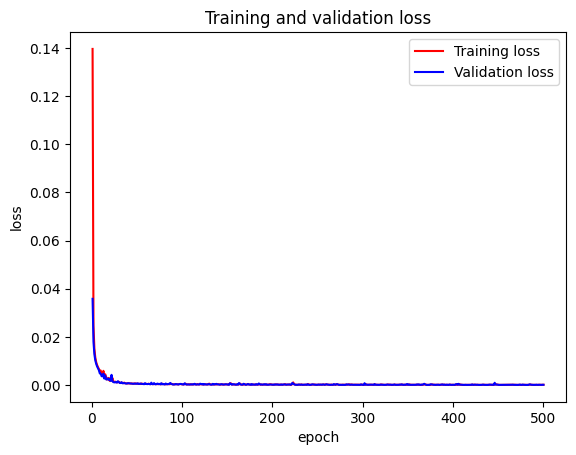

In [ ]:
# plot training and validation losses against epochs

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

C:\Users\wuwanlu\AppData\Local\Temp\ipykernel_4976\1097437374.py:12: RuntimeWarning: invalid value encountered in sqrt
  sqrt = np.sqrt(-2688000 * i**2 + 15772800000)


116/116 [==============================] - 1s 8ms/step


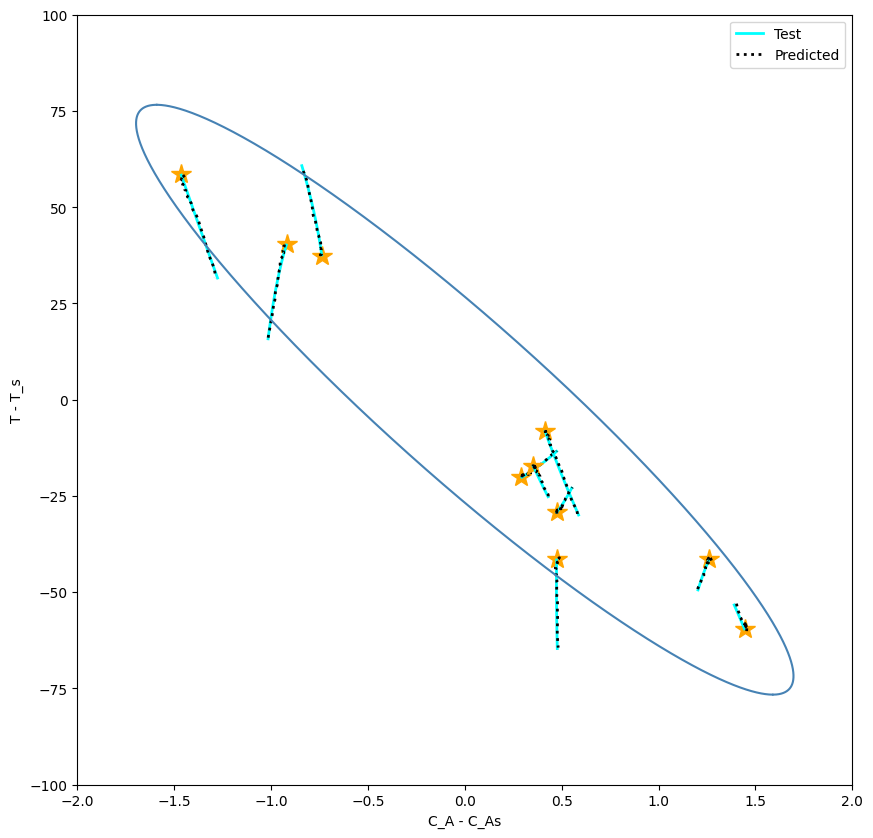

In [ ]:
"""
    equation for the stability ellipse is 1060x^2 + 44xy + 0.52y^2 - 372 = 0
"""
# prepare x and y coordinates for plotting the stability region
y = np.linspace(-100, 100, 100000, endpoint=True)

x_upper = list()
x_lower = list()
y_plot = list()

for i in y:
    sqrt = np.sqrt(-2688000 * i**2 + 15772800000)
    if sqrt >= 0:
        y_plot.append(i)
        x_upper.append((-4400 * i + sqrt) / 212000)
        x_lower.append((-4400 * i - sqrt) / 212000)
        pass
    pass


plt.figure(figsize=(10,10))

# plot the first 10 samples and their trajectories
y_predict = model.predict(X_test)

y_predict=y_predict.reshape(-1,2) #additional line
y_predict = scaler_y.inverse_transform(y_predict)
y_predict=y_predict.reshape(-1,100,2) #additional

X_plot=X_test.reshape(-1,4) #additional line
X_plot = scaler_X.inverse_transform(X_plot)
X_plot=X_plot.reshape(-1,100,4) #additional

for i in range(10):
    if i == 0:  # only add label to 1 data point
        plt.plot(X_plot[i, 0, -2], X_plot[i, 0, -1], marker="*", markersize=15, color='orange')
        plt.plot(y_test[i, :, 0], y_test[i, :, 1], color='cyan', lw=2, label='Test')
        plt.plot(y_predict[i, :, 0], y_predict[i, :, 1], color='black', lw=2, ls=':', label='Predicted')
    else:
        plt.plot(X_plot[i, 0, -2], X_plot[i, 0, -1], marker="*", markersize=15, color='orange')
        plt.plot(y_test[i, :, 0], y_test[i, :, 1], color='cyan', lw=2)
        plt.plot(y_predict[i, :, 0], y_predict[i, :, 1], color='black', lw=2, ls=':')


# plot stability region
plt.plot(x_lower, y_plot, color='steelblue')
plt.plot(x_upper, y_plot, color='steelblue')
plt.ylim([-100, 100])
plt.xlim([-2, 2])

plt.xlabel("C_A - C_As")
plt.ylabel("T - T_s")
plt.legend()
plt.show()


In [ ]:
model.save('eulermodel.h5')

c:\Users\wuwanlu\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
